In [1]:
### Load required Libraries
import pandas as pd
import io
import os, shutil
import cv2
import skimage
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.utils import class_weight
from keras.utils import plot_model

In [ ]:
### Required UDFs
def plot_PNG(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  plt.close(figure)
  buf.seek(0)
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  image = tf.expand_dims(image, 0)
  return image

In [ ]:
os.getcwd()

'/kaggle/working'

### Data Pre-processing

In [ ]:
im = cv2.imread('/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_train_data/img100.jpg')

print(type(im))
print(im.shape)
print(type(im.shape))

<class 'numpy.ndarray'>
(1479, 1793, 3)
<class 'tuple'>


In [ ]:
# Reading the Data
path = "/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/1. train_metadata.csv"
df_metadata = pd.read_csv(path)

img_path_list = df_metadata['path'].tolist()
img_class_list = df_metadata['class'].tolist()

print(df_metadata.shape)
df_metadata.head()

(10429, 2)


,path,class
0,img8223.jpeg,pneumonia
1,img4325.jpg,pneumonia
2,img6532.jpg,pneumonia
3,img10118.jpeg,pneumonia
4,img9961.jpeg,pneumonia


In [ ]:
total_class_names = list(df_metadata['class'].unique())
total_class_names

['pneumonia', 'healthy']

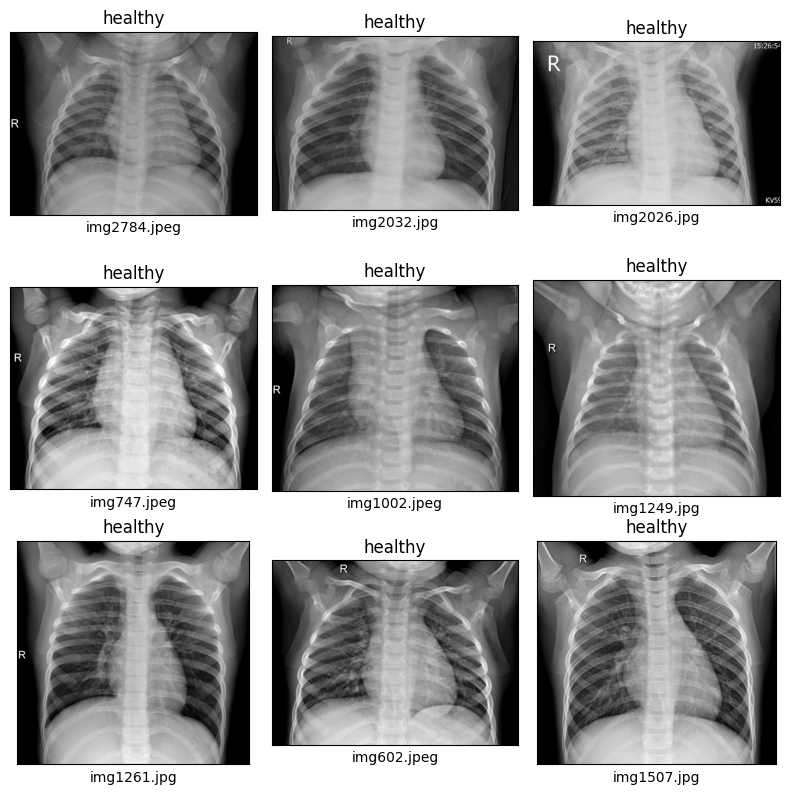

In [ ]:
# 1. Displaying the data
# Healthy class
healthy_list = df_metadata[df_metadata['class'] == "healthy"]['path'].to_list()
healthy_class_list = df_metadata[df_metadata['class'] == "healthy"]['class'].to_list()
n = 3 # Size of image grid 3x3
plt.figure(figsize=(8,8))

for i in range(n*n):
    plt.subplot(n,n,i+1)
    img = plt.imread(os.path.join(f"/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_train_data/{healthy_list[i]}"))
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(healthy_list[i])
    plt.title(healthy_class_list[i])
plt.tight_layout()

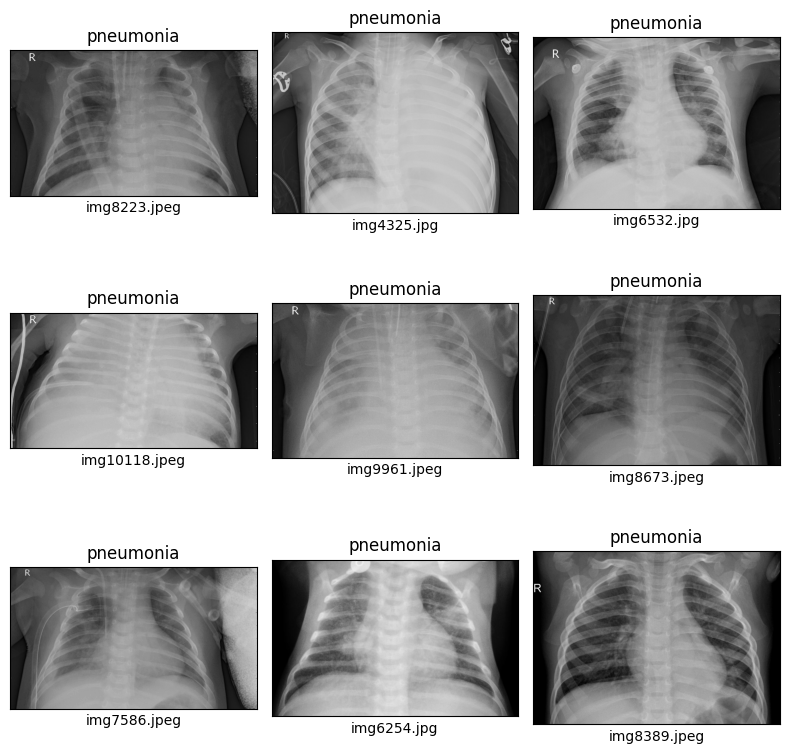

In [ ]:
# 1. Displaying the data
# Pneumonia class
pneumonia_list = df_metadata[df_metadata['class'] == "pneumonia"]['path'].to_list()
pneumonia_class_list = df_metadata[df_metadata['class'] == "pneumonia"]['class'].to_list()
n = 3 # Size of image grid 3x3
plt.figure(figsize=(8,8))

for i in range(n*n):
    plt.subplot(n,n,i+1)
    img = plt.imread(os.path.join(f"/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_train_data/{pneumonia_list[i]}"))
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(pneumonia_list[i])
    plt.title(pneumonia_class_list[i])
plt.tight_layout()

In [ ]:
# # 2. Explore distribution - understand the data
# from ydata_profiling import ProfileReport
# display(ProfileReport(df_metadata))

In [ ]:
print(len(healthy_list)) ; print(len(pneumonia_list))

3067
7362


In [ ]:
### Creating Input Train data in workspace
if not os.path.exists("/kaggle/working/Input/Train/healthy"):
    os.makedirs("/kaggle/working/Input/Train/healthy")

if not os.path.exists("/kaggle/working/Input/Train/pneumonia"):
    os.makedirs("/kaggle/working/Input/Train/pneumonia")

# Create Healthy subfolder
for i in range(len(healthy_list)):
    source = f"/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_train_data/{healthy_list[i]}"
    destination = f"/kaggle/working/Input/Train/healthy/{healthy_list[i]}"

    try:
        shutil.copy(source, destination)
#         print("File copied successfully.")
    except shutil.SameFileError:
        print("Source and destination represents the same file.")
    except PermissionError:
        print("Permission denied.")
    except:
        print("Error occurred while copying file.")

# Create Pneumonia subfolder
for i in range(len(pneumonia_list)):
    source = f"/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_train_data/{pneumonia_list[i]}"
    destination = f"/kaggle/working/Input/Train/pneumonia/{pneumonia_list[i]}"

    try:
        shutil.copy(source, destination)
#         print("File copied successfully.")
    except shutil.SameFileError:
        print("Source and destination represents the same file.")
    except PermissionError:
        print("Permission denied.")
    except:
        print("Error occurred while copying file.")

# shutil.rmtree("/kaggle/working/Input/Train/healthy") #To delete a folder

### Identify Corrupt Image files
# for i in range(len(healthy_list)):
#     print(healthy_list[i])
#     cv2.imread(f"/kaggle/working/Input/Train/healthy/{healthy_list[i]}")
# Delete corrupt file

# if os.path.exists("/kaggle/working/Input/Train/img2544.jpg"):
#   img = cv2.imread("/kaggle/working/Input/Train/img2544.jpg")

# plt.imshow(img)
# plt.show()

os.remove("/kaggle/working/Input/Train/healthy/img2544.jpeg")

In [ ]:
## 3c. Data composition into tf format
batch_size = 32
img_height = 256
img_width = 256

# train_path = "/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_train_data/"
train_path = "/kaggle/working/Input/Train/"

train_datagen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     validation_split=0.1)

train_generator = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height, img_width),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode='binary',
                                              subset='training')

validation_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   class_mode='binary',
                                                   subset='validation')

Found 9386 images belonging to 2 classes.
Found 1042 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'healthy': 0, 'pneumonia': 1}

In [ ]:
### Reduce Class Imbalance
x_train, y_train = next(train_generator)
x_val, y_val = next(validation_generator)

class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.7777777777777777, 1: 0.6956521739130435}

### Model Development

In [2]:
# CNN Base Layers
model = models.Sequential()
model.add(layers.InputLayer(shape = (256, 256, 3)))
model.add(layers.RandomRotation(0.2))
model.add(layers.RandomContrast(0.1))
# CNN Block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# CNN Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# CNN Block 3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# CNN Block 4
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Block 5 : Top Classifier
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_rotation (RandomRotation)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,534,018 (51.63 MB)

 Trainable params: 13,534,018 (51.63 MB)

 Non-trainable params: 0 (0.00 B)

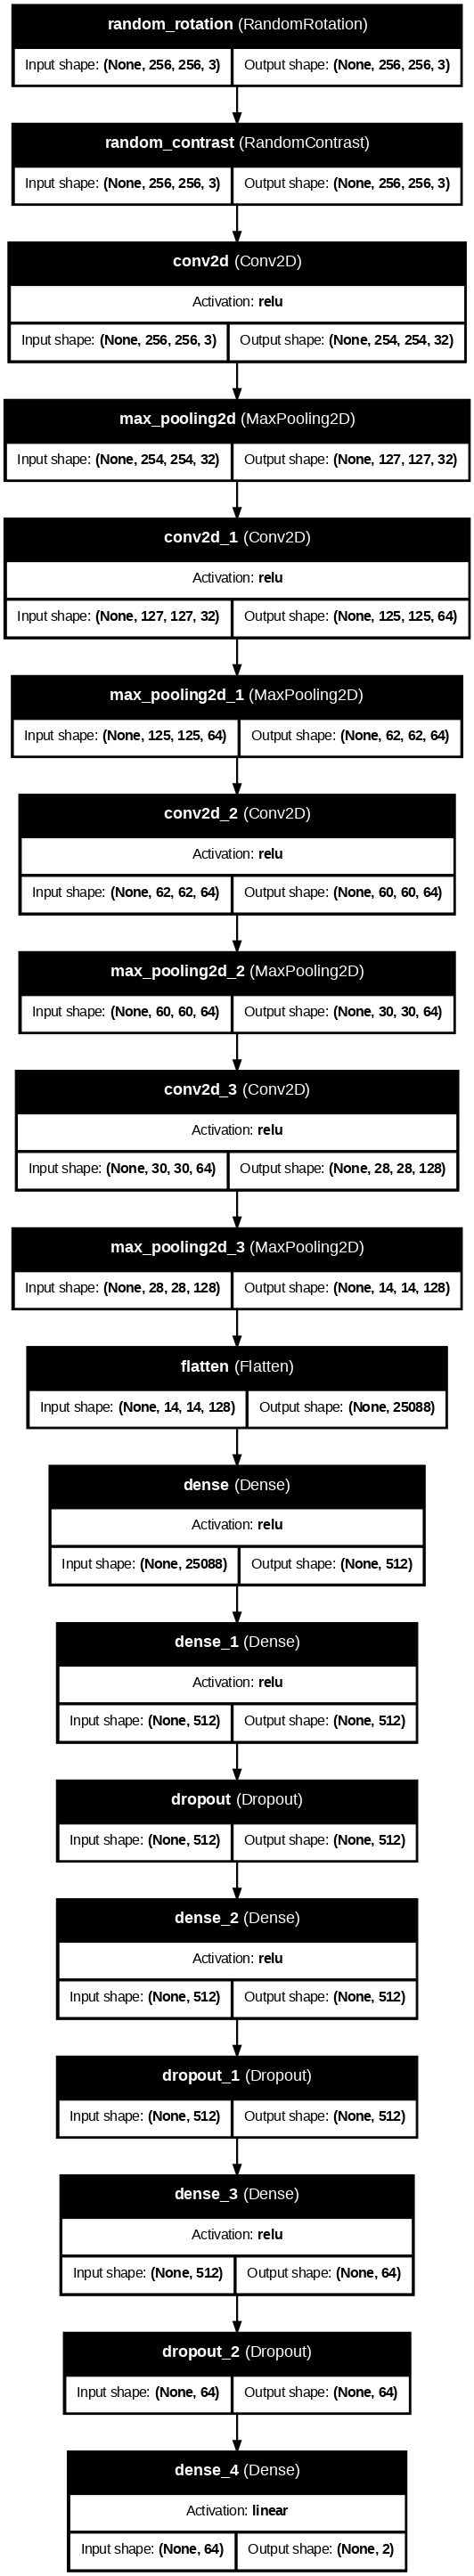

In [5]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=80, show_layer_activations=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) #tf.keras.metrics.F1Score()

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            restore_best_weights=True)
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=50, class_weight=class_weights_dict,
                    callbacks=[earlystop_callback, class_weight=class_weights_dict])

# model.save_weights('first_attempt.h5')  # save weights after training

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


294/294 ━━━━━━━━━━━━━━━━━━━━ 252s 816ms/step - accuracy: 0.6136 - loss: 0.6266 - val_accuracy: 0.7572 - val_loss: 0.5514
Epoch 2/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 241s 801ms/step - accuracy: 0.7785 - loss: 0.4524 - val_accuracy: 0.7630 - val_loss: 0.4821
Epoch 3/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 242s 805ms/step - accuracy: 0.7990 - loss: 0.4331 - val_accuracy: 0.7255 - val_loss: 0.5983
Epoch 4/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 242s 807ms/step - accuracy: 0.8193 - loss: 0.3874 - val_accuracy: 0.8071 - val_loss: 0.4669
Epoch 5/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 262s 807ms/step - accuracy: 0.8448 - loss: 0.3664 - val_accuracy: 0.8109 - val_loss: 0.5450
Epoch 6/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 241s 803ms/step - accuracy: 0.8459 - loss: 0.3578 - val_accuracy: 0.7985 - val_loss: 0.4686
Epoch 7/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 241s 803ms/step - accuracy: 0.8498 - loss: 0.3510 - val_accuracy: 0.8177 - val_loss: 0.4424
Epoch 8/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 242s 804ms/step - accuracy: 0.8569 - loss: 0.32

In [ ]:
model.evaluate(validation_generator)

33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 733ms/step - accuracy: 0.8467 - loss: 0.3811


[0.3901827931404114, 0.8474088311195374]

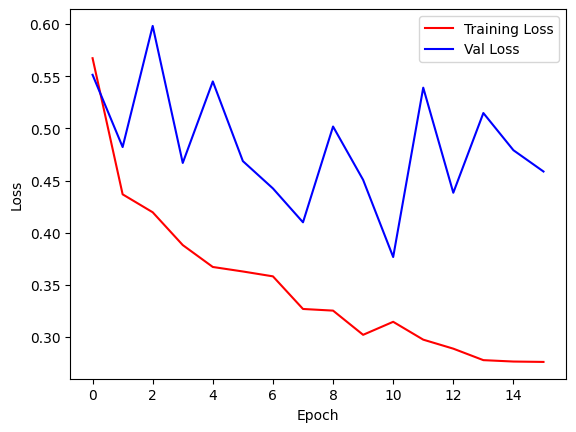

In [ ]:
# 4. Enable tensorboard for tracking
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing and Creating Output

In [ ]:
# class dictionary
class_dict = train_generator.class_indices

# list out keys and values separately
key_list = list(class_dict.keys())
val_list = list(class_dict.values())

# print key with val 0
position = val_list.index(0)
print("Class 0 :", key_list[position])

# print key with val 1
position = val_list.index(1)
print("Class 1 :", key_list[position])

Class 0 : healthy
Class 1 : pneumonia


In [ ]:
### Creating Test data in workspace
# test_path = "/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_test_set/"
path = "/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/2. test_files.csv"
df_test = pd.read_csv(path)

test_list = df_test['path'].to_list()
print(len(test_list))

# Create Test subfolder
if not os.path.exists("/kaggle/working/Test/test"):
    os.makedirs("/kaggle/working/Test/test")

for i in range(len(test_list)):
    source = f"/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/processed_test_set/{test_list[i]}"
    destination = f"/kaggle/working/Test/test/{test_list[i]}"
    shutil.copy(source, destination)

1928


In [6]:
# Do the same pre-processing/formatting as the training set for the test set - remember to use batch_size 1 for testing

# Evaluate trained model on test set - Creating output file for submission - Template Code
submission = pd.DataFrame(columns=['ID','class']); c = 0

for i in range(len(test_list)):
    test_path = f"/kaggle/working/Test/test/{test_list[i]}"
#     print(c, f". Prediction for {test_list[i]} ...")

    img = image.load_img(test_path, target_size = (256, 256))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)

    y_pred = model.predict(img, verbose=0)
#     print(y_pred)
    y_pred_bool = np.argmax(y_pred, axis=1) # Return the index of max value

    idx = y_pred_bool[0]
    position = val_list.index(idx)
    pred_class = key_list[position]

    results_dict = {'ID': c, 'class': pred_class}
    submission = submission._append(results_dict, ignore_index = True); del results_dict; c = c + 1

# submission.head()

In [ ]:
# Save results to CSV
submission.to_csv('output_submission_eval.csv', index=False)

In [ ]:
# test_pd = pd.read_csv('/kaggle/input/123-of-ai-presents-pneumonia-detection-from-xray/3. sample_submission.csv')
# test_pd.head(2) # sample output

,ID,class
0,0,pneumonia
1,1,healthy
